# Data description & Problem statement: 
This data set is collected from recordings of 30 human subjects captured via smartphones enabled with embedded inertial sensors.
In this project, we calculate a model by which a smartphone can detect its owner’s activity precisely. For the dataset, 30 people were used to perform 6 different activities. Each of them was wearing a Samsung Galaxy SII on their waist. Using the smartphone’s embedded sensors (the accelerometer and the gyroscope), the user’s speed and acceleration were measured in 3-axial directions. We use the sensor’s data to predict user’s activity.

* Dataset is imbalanced. The data has 10299 rows and 561 columns.
* This is a Multiclass-classification problem. 

# Workflow:
- Load the dataset, and define the required functions (e.g. for detecting the outliers)
- Data Cleaning/Wrangling: Manipulate outliers, missing data or duplicate values, Encode categorical variables, etc.
- Split data into training & test parts (utilize the training part for training & hyperparameter tuning of model, and test part for the final evaluation of model)
   #  Model Training:
- Build an XGBoost model, and evaluate it via C-V approach

   # Model Evaluation: 
- Evaluate the XGBoost model with optimized hyperparameters on Test Dataset, by calculating:
     - f1_weighted
     - Confusion matrix

In [1]:
import sklearn
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
%matplotlib inline

from scipy import stats

import warnings
warnings.filterwarnings("ignore")

In [2]:
df_X=pd.read_csv('C:/Users/rhash/Documents/Datasets/Human activity recognition/UCI HAR Dataset/train/X_train.txt' 
                                ,delim_whitespace=True, header = None) 

df_y=pd.read_csv('C:/Users/rhash/Documents/Datasets/Human activity recognition/UCI HAR Dataset/train/y_train.txt' 
                                ,delim_whitespace=True, header = None, names=['Label']) 

df = pd.concat([df_y, df_X], axis=1)  

# To Shuffle the data:
np.random.seed(42)
df=df.reindex(np.random.permutation(df.index))
df.reset_index(inplace=True, drop=True)

df.head(3)

,Label,0,1,2,3,4,5,6,7,8,...,551,552,553,554,555,556,557,558,559,560
0,5,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,...,-0.074323,-0.298676,-0.710304,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627
1,5,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,...,0.158075,-0.595051,-0.861499,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317
2,5,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,...,0.414503,-0.390748,-0.760104,-0.118559,0.177899,0.100699,0.808529,-0.848933,0.180637,-0.049118


In [13]:
df.to_csv('df_All.csv', header=True, index=False)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7352 entries, 0 to 7351
Columns: 562 entries, Label to 560
dtypes: float64(561), int64(1)
memory usage: 31.5 MB


In [3]:
# Data is slightly imbalanced:
df['Label'].value_counts()

6    1407
5    1374
4    1286
1    1226
2    1073
3     986
Name: Label, dtype: int64

In [4]:
X=df.drop('Label', axis=1)
y=df['Label']

In [5]:
# We initially devide data into training & test folds:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify = y)

In [6]:
# Build and fit the XGB model: 
import xgboost
from xgboost import XGBClassifier

# We create a sample_weight list for this imbalanced dataset:
from sklearn.utils.class_weight import compute_sample_weight
sw=compute_sample_weight(class_weight='balanced', y=y_train)

xgb=XGBClassifier(max_depth=6, n_estimators=200, subsample=0.7) 
#model = xgb.fit(X_train, y_train, sample_weight=sw, eval_metric="merror")
model = xgb.fit(X_train, y_train, eval_metric="merror")

Confusion matrix, without normalization
[[306   0   1   0   0   0]
 [  0 268   0   0   0   0]
 [  0   1 245   0   0   0]
 [  0   0   0 312  10   0]
 [  0   0   0   1 342   0]
 [  0   0   0   0   0 352]]
Normalized confusion matrix
[[1.   0.   0.   0.   0.   0.  ]
 [0.   1.   0.   0.   0.   0.  ]
 [0.   0.   1.   0.   0.   0.  ]
 [0.   0.   0.   0.97 0.03 0.  ]
 [0.   0.   0.   0.   1.   0.  ]
 [0.   0.   0.   0.   0.   1.  ]]


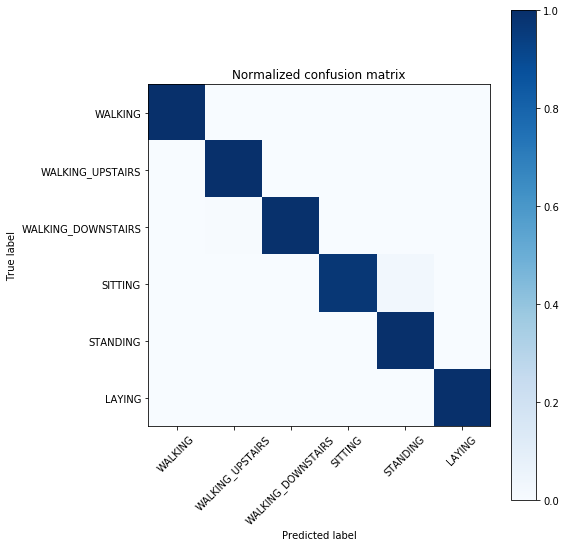

In [7]:
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report

# Plot a confusion matrix.
# cm is the confusion matrix, names are the names of the classes.
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    fig, ax = plt.subplots(1,1,figsize=(8,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

names = ["WALKING", "WALKING_UPSTAIRS", "WALKING_DOWNSTAIRS", "SITTING", "STANDING", "LAYING"]

# Compute confusion matrix
cm = confusion_matrix(y_test, model.predict(X_test))
np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
print(cm)

# Normalize the confusion matrix by row (i.e by the number of samples in each class)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
print(cm_normalized)

plot_confusion_matrix(cm_normalized, names, title='Normalized confusion matrix')

In [8]:
# Classification report:
report=classification_report(y_test, model.predict(X_test))
print(report)

             precision    recall  f1-score   support

          1       1.00      1.00      1.00       307
          2       1.00      1.00      1.00       268
          3       1.00      1.00      1.00       246
          4       1.00      0.97      0.98       322
          5       0.97      1.00      0.98       343
          6       1.00      1.00      1.00       352

avg / total       0.99      0.99      0.99      1838



In [9]:
# Cross-Validation over entire data: 
import xgboost
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

kfold=StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
scores=cross_val_score(xgb, X, y, cv=kfold, scoring="f1_weighted", n_jobs=-1)

print(scores, "\n")
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))

[0.99 0.99 0.99] 

Accuracy: 0.99 (+/- 0.00)
